In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

In [3]:
file_dir = '../input/garbage-classification/Garbage classification/Garbage classification'
classes = os.listdir(file_dir)
print(classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [4]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
# resizing the data
trans = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
dataset = ImageFolder(file_dir, transform = trans)

# randomly split dataset for train, validation and test
rand_seed = 81
torch.manual_seed(rand_seed)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train, val, test = random_split(dataset, (train_size, val_size, test_size))
print(len(train), len(val), len(test))

# load train and validation dataset with dataloader
batch_size  = 32
train_dl = DataLoader(train, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

2021 252 254


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()} 
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [6]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=00ea458b3931767c3631212ae277770dbd1d6ae4d68b235a0d143e09acbcbf3c
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [7]:
import torchvision.models as models
from efficientnet_pytorch import EfficientNet

class EffNet(ClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = EfficientNet.from_pretrained('efficientnet-b4')
        in_features = self.network._fc.in_features
        self.network._fc = nn.Linear(in_features, len(dataset.classes))
    
    def forward(self, xb):
        return F.relu(self.network(xb))

model = EffNet()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [9]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

EffNet(
  (network): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_pro

In [10]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [11]:
evaluate(model, val_dl)

{'val_loss': 1.802565574645996, 'val_acc': 0.1579241007566452}

In [12]:
num_epochs = 12
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.6602, val_loss: 1.5264, val_acc: 0.6629
Epoch 2: train_loss: 1.0858, val_loss: 0.9296, val_acc: 0.7874
Epoch 3: train_loss: 0.5918, val_loss: 0.5890, val_acc: 0.8454
Epoch 4: train_loss: 0.3546, val_loss: 0.4434, val_acc: 0.8616
Epoch 5: train_loss: 0.2294, val_loss: 0.3478, val_acc: 0.8956
Epoch 6: train_loss: 0.1458, val_loss: 0.2859, val_acc: 0.9247
Epoch 7: train_loss: 0.1016, val_loss: 0.2833, val_acc: 0.9185
Epoch 8: train_loss: 0.0751, val_loss: 0.2565, val_acc: 0.9247
Epoch 9: train_loss: 0.0698, val_loss: 0.2377, val_acc: 0.9364
Epoch 10: train_loss: 0.0595, val_loss: 0.2499, val_acc: 0.9453
Epoch 11: train_loss: 0.0425, val_loss: 0.2497, val_acc: 0.9408
Epoch 12: train_loss: 0.0447, val_loss: 0.2590, val_acc: 0.9358


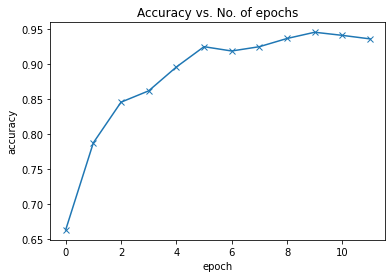

In [13]:
import matplotlib.pyplot as plt
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

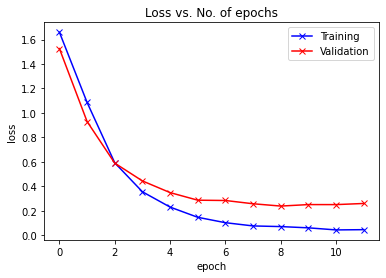

In [14]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [15]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [16]:
test_dl = DataLoader(test, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_dl = DeviceDataLoader(test_dl, device)
evaluate(model, test_dl)

{'val_loss': 0.17597991228103638, 'val_acc': 0.9489583373069763}

In [17]:
import gc
gc.collect()

6598

In [18]:
torch.save(model.state_dict(), "./weight.pth")

In [19]:
torch.cuda.empty_cache()